# Spike Computational Neuroscience Community
## EEG Processing: An Entry to the World of Brain Waves
### TOPIC: Event-Related Potential (ERP)
##    
<div style="font-family: Arial, sans-serif; margin: 20px;">
    <p style="text-align: center; color: #666; font-size: 16px;">
        Author: Mohammadreza Shahsavari<br>
        Contact: <a href="mailto:mohamadrezashahsavary@gmail.com" style="color: #0066cc; text-decoration: none;">mohamadrezashahsavary@gmail.com</a>
    </p>
</div>







# Part 1: Introduction
Welcome to this tutorial on event-related EEG data analysis. In this session, we will focus on working with
triggers, defining trials, and calculating Event-Related Potentials (ERPs) using the MNE library in Python.

Objectives:
- Understand how to handle event-based EEG data.
- Define trials based on specific triggers.
- Compute and visualize ERPs.

Dataset: We will use the sample dataset from the MNE library, which contains EEG data from an auditory oddball paradigm.

# Part 2: Loading and Exploring the Data


In [ ]:
!pip install mne

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12

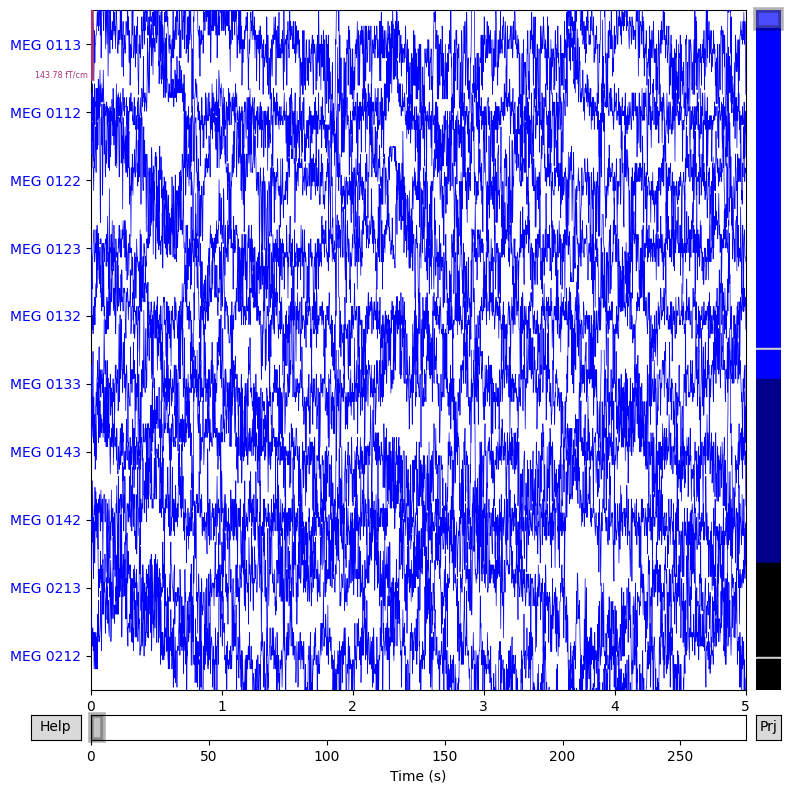

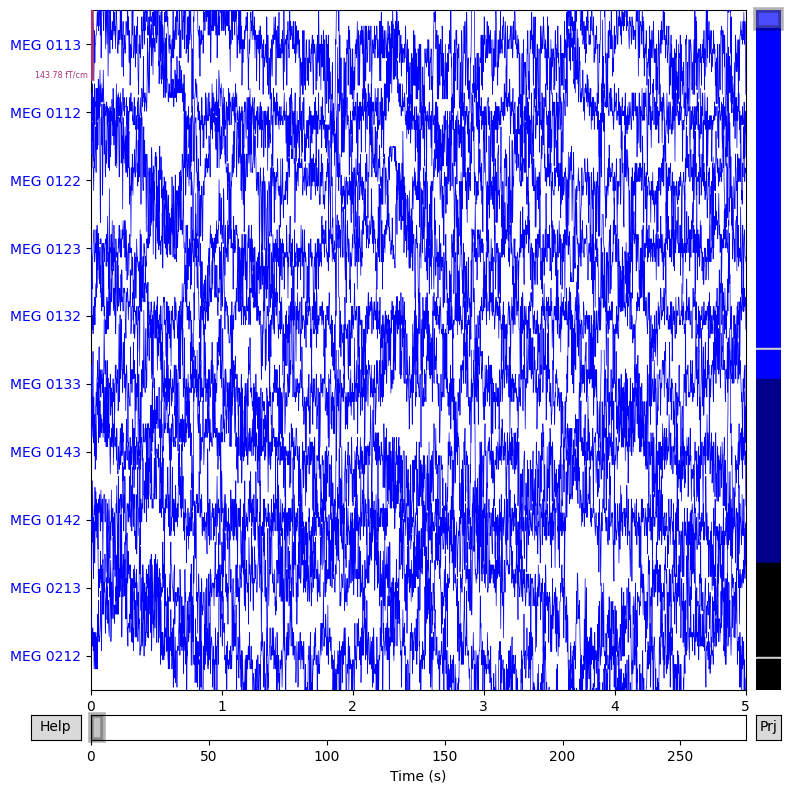

In [ ]:
# Importing necessary libraries
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load MNE sample dataset
mne.datasets.sample.data_path(verbose=True)
data_path = str(mne.datasets.sample.data_path())

# Define file path for raw data
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

# Load raw EEG data
raw = mne.io.read_raw_fif(raw_fname, preload=True)

# Basic information about the dataset
print(raw.info)

# Plot raw data to inspect visually
raw.plot(n_channels=10, duration=5, scalings='auto')


# Part 3: Event Triggers and Marker Extraction

In EEG experiments, event triggers are markers that denote the occurrence of specific events during the recording.
These could be stimulus presentations, participant responses, or other experimental events. In MNE, event triggers
are extracted from the raw EEG data and are stored as a numpy array with the following structure:

[Sample number, Previous trigger value, Current trigger value]

- Sample number: The time point in samples where the event occurred.
- Previous trigger value: The trigger value immediately before the current event.
- Current trigger value: The trigger code associated with the current event.

Let's examine how triggers are extracted and stored step by step.

In [ ]:

# Extract events from the raw data
print("Extracting events from raw data...")
events = mne.find_events(raw, stim_channel='STI 014')

# Display the first 10 events
print("First 10 events:\n", events[:10])


Extracting events from raw data...
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
First 10 events:
 [[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]
 [30025     0     3]
 [30450     0     1]
 [30839     0     4]
 [31240     0     2]
 [31665     0     3]]


Explanation of the Output:
- Each row is an event.
- The first column indicates the sample number where the event occurred.
- The second column indicates the previous trigger value.
- The third column indicates the current trigger value.

Example:
[2631, 0, 1]
- Event occurred at sample 2631.
- No previous trigger (0).
- Current trigger value is 1.

In [ ]:
# Checking the number of events and unique triggers
print(f"Total number of events: {len(events)}")
print(f"Unique event codes: {np.unique(events[:, 2])}")

Total number of events: 320
Unique event codes: [ 1  2  3  4  5 32]


We can define meaningful labels for event codes using a dictionary.


In [ ]:
# Defining event labels for clarity
event_id = {
    'Auditory/Left': 1,
    'Auditory/Right': 2,
    'Visual/Left': 3,
    'Visual/Right': 4
}

print("Event labels:", event_id)


Event labels: {'Auditory/Left': 1, 'Auditory/Right': 2, 'Visual/Left': 3, 'Visual/Right': 4}


Visualizing the events can help in understanding their distribution.


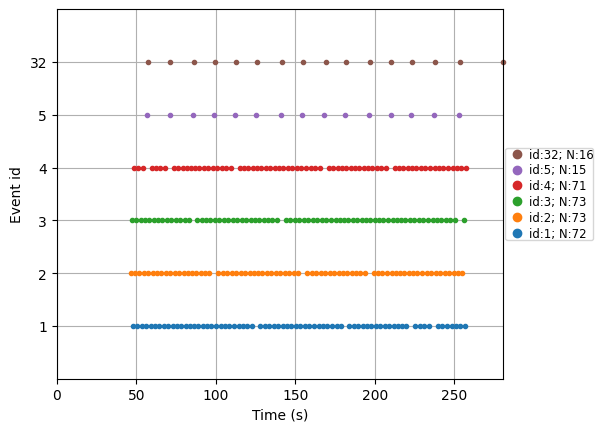

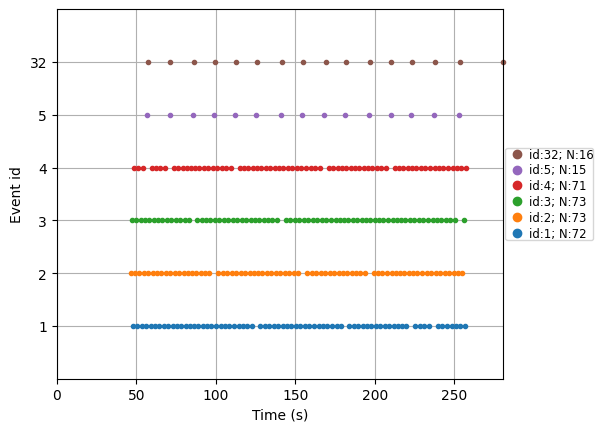

In [ ]:
# Plot the events to visualize distribution
mne.viz.plot_events(events, sfreq=raw.info['sfreq'])

# Part 4: Defining Trials (Epoching)


Epoching is the process of segmenting continuous EEG data into time-locked segments around events.
This is crucial for studying brain responses to specific stimuli.

Parameters for Epoching:
- tmin: Start time before the event in seconds (negative values for pre-event).
- tmax: End time after the event in seconds.
- baseline: Time interval for baseline correction (usually pre-stimulus).

Let's define these parameters and create epochs.

In [ ]:
tmin = -0.2  # 200 ms before the event
tmax = 0.5   # 500 ms after the event
baseline = (None, 0)  # From start to event onset

# Creating epochs
epochs = mne.Epochs(
    raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
    baseline=baseline, preload=True
)

# Display basic information about the epochs
print(epochs)

Not setting metadata
289 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 289 events and 421 original time points ...
0 bad epochs dropped
<Epochs | 289 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~352.2 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73
 'Visual/Left': 73
 'Visual/Right': 71>


Inspecting epochs provides an overview of the segmented trials.


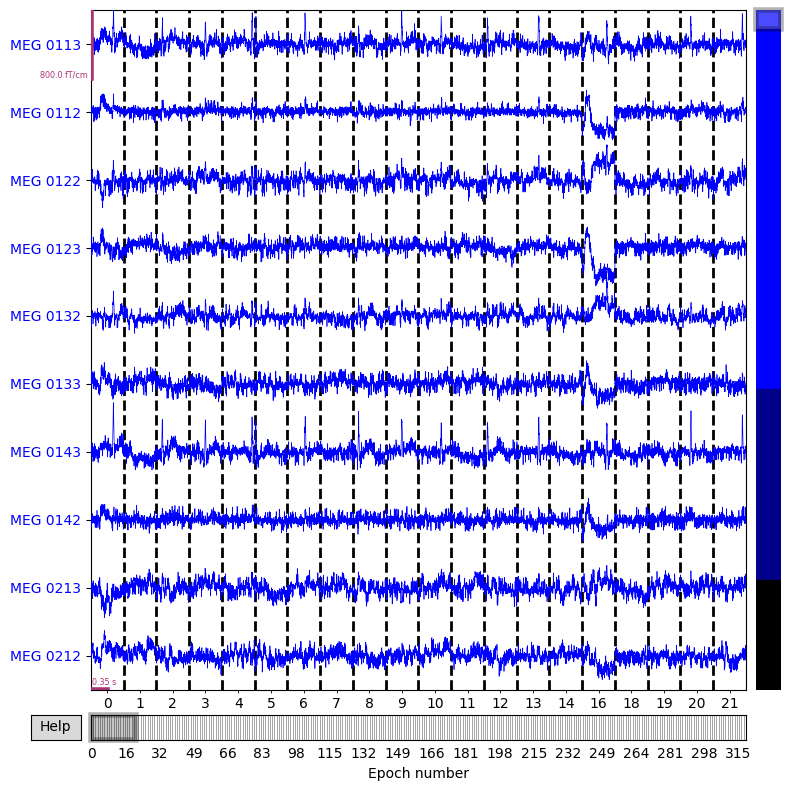

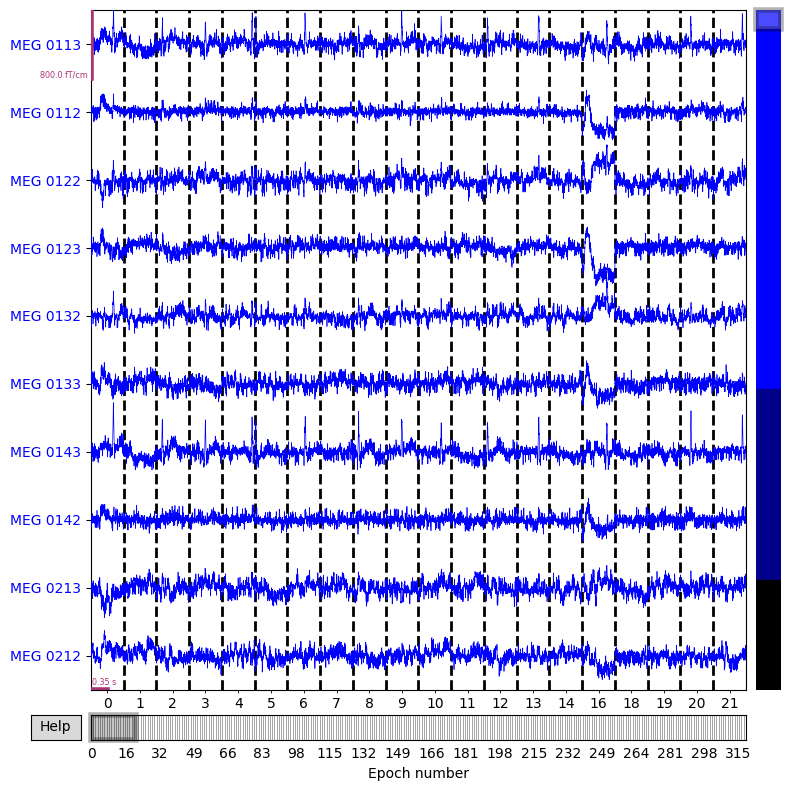

In [ ]:
# Visualizing the epochs
epochs.plot(n_channels=10, block=True)


Why Baseline Correction?
Baseline correction adjusts the epochs so that the mean voltage in the baseline period (before stimulus) is zero.
This helps in removing slow drifts and makes waveforms comparable across trials.

Next Steps:
In the upcoming section, we will focus on artifact rejection to ensure that noisy or corrupted epochs are removed
before calculating ERPs.

# Part 5: Artifact Rejection in Epochs

Artifact rejection is a crucial step in EEG analysis to ensure the quality and reliability of ERP results.
Artifacts can arise from various sources such as:
- Eye blinks and eye movements (EOG artifacts)
- Muscle activity (EMG artifacts)
- Power line noise
- Sudden electrode jumps

In MNE, artifact rejection can be done both automatically and manually. This section covers:
- Automatic rejection based on amplitude thresholds
- Manual rejection by visual inspection
- Handling noisy channels


## 1. Automatic Rejection Based on Peak-to-Peak Amplitude

MNE allows automatic rejection by specifying amplitude thresholds for different channel types.
This is useful for quickly excluding trials with large, non-physiological amplitudes.

Example Thresholds:
- EEG: 100 microvolts (uV)
- EOG: 150 microvolts (uV)

These thresholds can be adjusted based on data quality.


In [ ]:
# Define rejection criteria
reject_criteria = dict(eeg=100e-6, eog=150e-6)  # 100 uV for EEG, 150 uV for EOG

# Apply automatic rejection
epochs_autoreject = epochs.copy().drop_bad(reject=reject_criteria)

print(f"Number of epochs before rejection: {len(epochs)}")
print(f"Number of epochs after rejection: {len(epochs_autoreject)}")

    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007'

Notice how some trials were dropped based on our amplitude thresholds.

Automatic rejection is efficient but might remove good trials if thresholds are too strict.
For better control, we can perform manual rejection.


## 2. Manual Rejection by Visual Inspection


Manual rejection involves inspecting epochs visually and marking bad trials.
This approach is more time-consuming but can preserve good data.

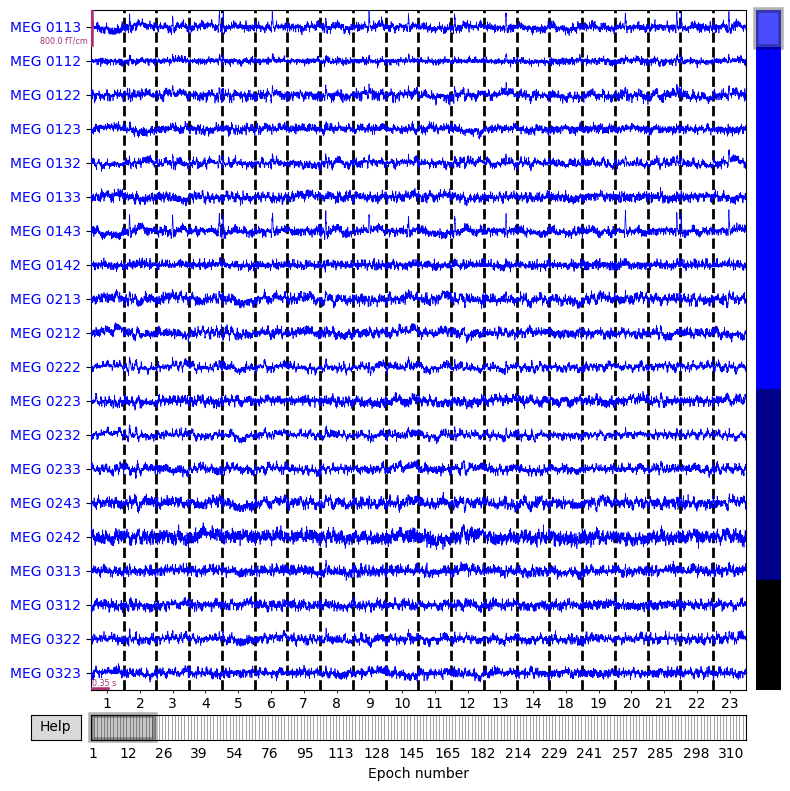

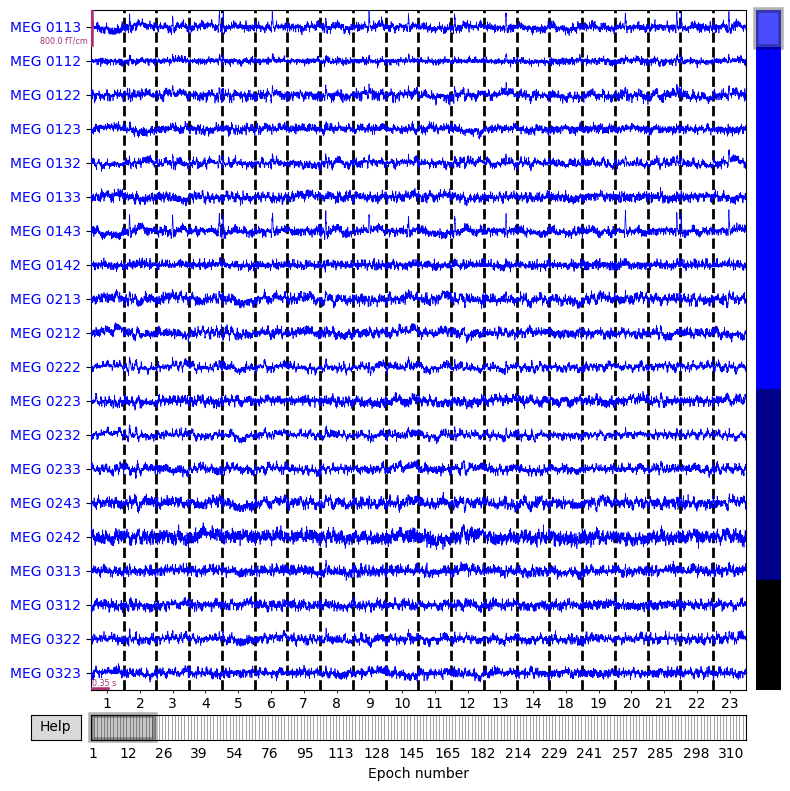

In [ ]:
# Plot epochs for manual inspection
epochs_autoreject.plot(block=True)

In the interactive plot:
- Click on epochs to mark them as bad (they turn red).
- Click again to unmark.

After manual inspection, we can drop the marked epochs.

In [ ]:
# Drop manually marked bad epochs
epochs_autoreject.drop_bad()

print(f"Number of epochs after manual rejection: {len(epochs_autoreject)}")



## 3. Handling Noisy Channels

Noisy channels can degrade data quality. MNE provides tools to detect and exclude bad channels.


In [ ]:
# Detect bad channels based on flatness or high noise
raw.info['bads'] = []  # Initialize empty list for bad channels

# Automatically detect flat channels
flat_channels = mne.preprocessing.find_bad_channels_maxwell(raw)[0]
print(f"Flat channels detected: {flat_channels}")

# Add detected channels to the bads list
raw.info['bads'].extend(flat_channels)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    6.8s


Scanning for bad channels in 55 intervals (5.0 s) ...
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.8 mm in the head frame
        Interval   1:    0.000 -    4.998
        Interval   2:    5.000 -    9.998
        Interval   3:   10.000 -   14.998
        Interval   4:   15.000 -   19.998
        Interval   5:   20.000 -   24.998
        Interval   6:   24.999 -   29.998
        Interval   7:   29.999 -   34.997
        Interval   8:   34.999 -   39.997
        Interval   9:   39.999 -   44.997
        Interval  10:   44.999 -   49.997
        Interval  11:   49.999 -   54.997
        Interval  12:   54.999 -   59.997
        Interval  13:   59.999 -   64.997
        Interval  14:   64.998 -   69.997
        Interval  15:   69.998 -   74.996
        Interval  16:   74.998 -   79.996
        Interval  17:   79.998 -   84.996
        Interval  18:   84.998 -   89.996
        

After identifying bad channels, we can interpolate them or exclude them from analysis.

Next Steps:
In the next part, we will proceed to calculate ERPs from the cleaned epochs.

Setting channel interpolation method to {'eeg': 'spline', 'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
    Computing dot products for 305 MEG channels...
    Computing cross products for 305 → 1 MEG channel...
    Preparing the mapping matrix...
    Truncating at 85/305 components to omit less than 0.0001 (9.4e-05)


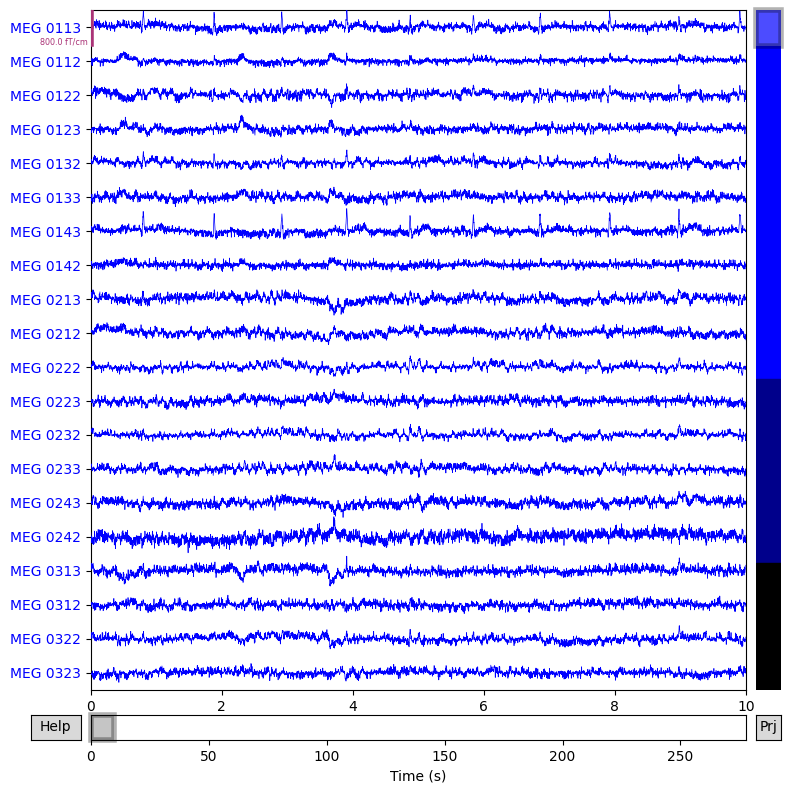

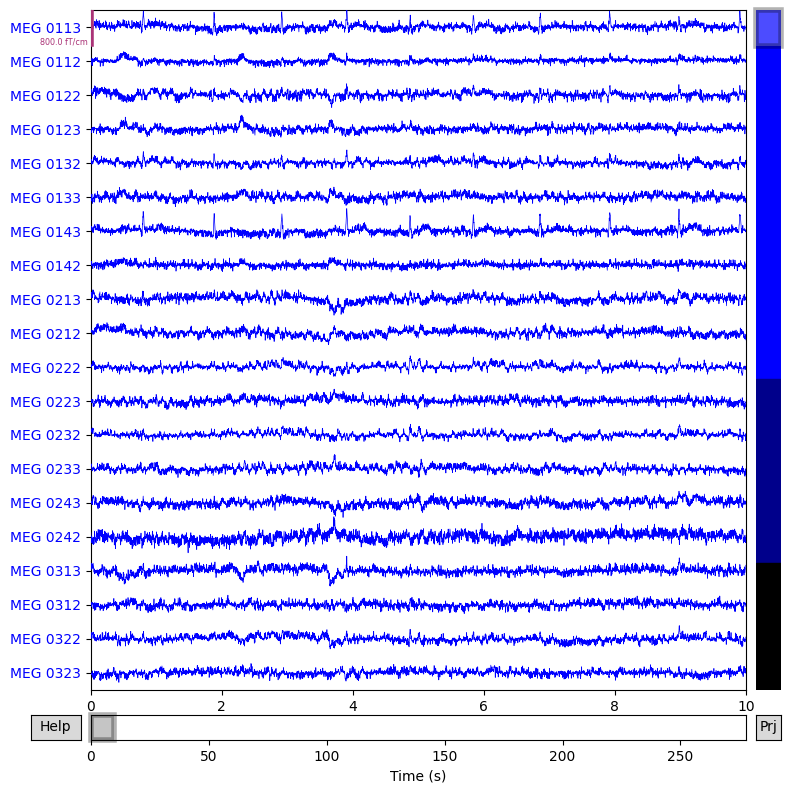

In [ ]:
# Interpolate the bad channels
raw.interpolate_bads(reset_bads=True)

# Plot to check the result
raw.plot()

# Part 6: Calculating ERPs

Event-Related Potentials (ERPs) are calculated by averaging epochs for each condition.
This averaging process enhances signal-to-noise ratio by canceling out random noise,
leaving only the consistent brain responses to specific events.

In this section, we will:
- Average epochs for each condition
- Visualize ERP waveforms
- Compare conditions (e.g., left vs. right auditory stimuli)

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


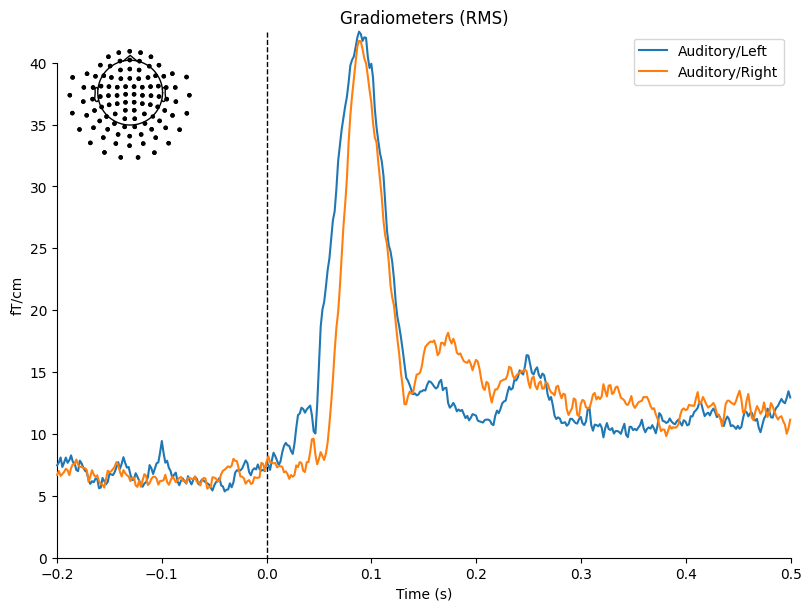

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


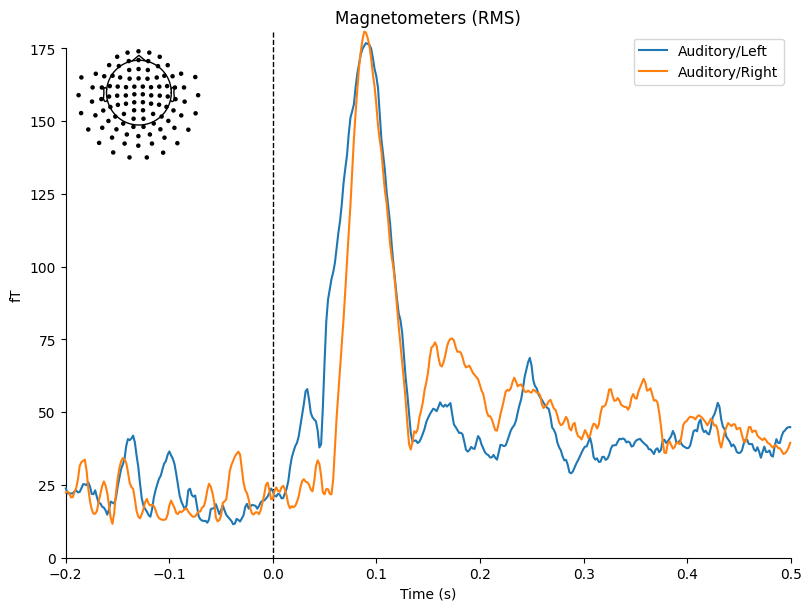

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


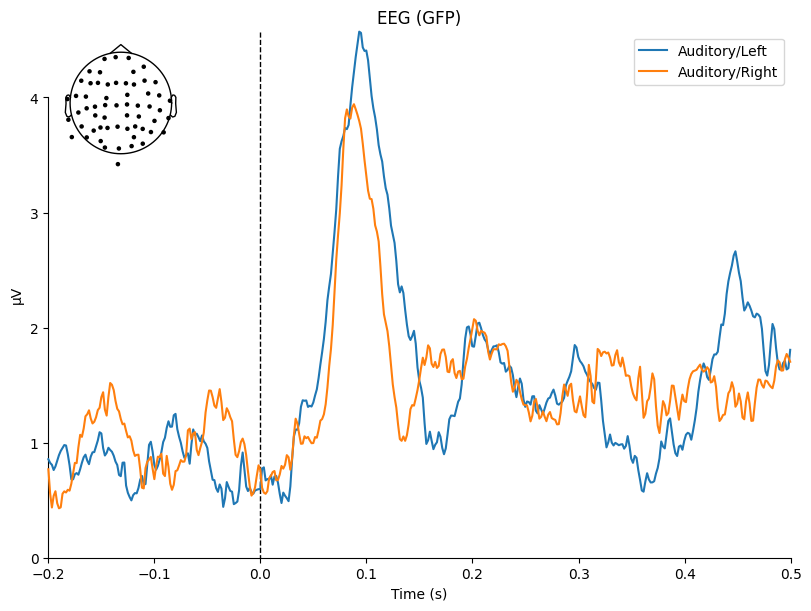

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [ ]:

# Averaging epochs to create ERPs
erp_left = epochs['Auditory/Left'].average()
erp_right = epochs['Auditory/Right'].average()

# Plotting ERP waveforms
mne.viz.plot_compare_evokeds([erp_left, erp_right],
                             legend='upper right',
                             show_sensors='upper left')


Explanation:
- The plot shows ERP waveforms for the two conditions.
- Shaded areas indicate standard error of the mean (SEM).
- Peaks in the waveform (e.g., P300, N170) can reveal cognitive processes.

Comparing Conditions:
Differences in amplitude or latency between conditions can provide insights
into brain responses to different stimuli.

# Part 7: Statistical Analysis of ERPs

Statistical analysis is essential for validating whether observed differences
between conditions are significant or due to chance.

In this section, we will:
- Define time windows of interest (e.g., 200-300 ms)
- Run statistical tests (t-tests, ANOVA)
- Correct for multiple comparisons

In [ ]:
from scipy.stats import ttest_rel

# Define time window of interest (200 to 300 ms)
time_window = (0.2, 0.3)
time_mask = (erp_left.times >= time_window[0]) & (erp_left.times <= time_window[1])

# Extract data in the time window
left_data = erp_left.data[:, time_mask].mean(axis=1)
right_data = erp_right.data[:, time_mask].mean(axis=1)

# Run paired t-test
t_stat, p_val = ttest_rel(left_data, right_data)
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: 6.6779036047991704, p-value: 9.050544859101104e-11


Interpretation:
- If p-value < 0.05, the difference is considered statistically significant.
- This indicates a reliable difference in brain response between conditions.

Multiple Comparisons:
When testing multiple time points, we need to adjust for multiple comparisons
to avoid false positives. Methods like Bonferroni or False Discovery Rate (FDR)
corrections can be used.

Next Steps:
In the final section, we will summarize key findings and discuss further reading.